Install and import necessary libraries 

In [20]:
# !pip update yfinance
# !pip install yfinance --upgrade --no-cache-dir #Uncomment pip install lines if needed
from datetime import date
import numpy as np
import pandas as pd
%matplotlib inline
import pandas_datareader.data as web
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


Bitcoin Regression

This notebook analyze six different scenarios:

1. Bitcoin's relationship to the overall market over the past 3 years
2. Bitcoin's relationship to the equity markets over the past 3 years
3. Bitcoin's relationship to the equity markets in crypto bull-run
4. Bitcoin's relationship to the equity markets in crypto winter
5. Bitcoin's relationship to the overall markets in crypto bull-run
6. Bitcoin's relationship to the overall markets in crypto winter

<b>Function lr_data_cleanser( ) </b>

equity_lr_data_cleanser( ) takes in optional arguements (start_date="yyyy-mm-dd",end_date="yyyy-mm-dd", interval_="1d") where interval is the itnerval of pricing data this should be formatted as a string and can be any of the following:1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo 

This function returns a dataframe of the returns for Bitcoin and the following securities: ACWI, MMN=F, VIX, CL=F (oil), GLD, FGBFX, TPINX, DX-Y.NYB (US Dollar), BAA10Y, em_currency

In [23]:
def lr_data_cleanser(start_date="2020-01-01",end_date=date.today().strftime('%Y-%m-%d'), interval_='1d'):

    #Download Bond Data (already in perecent change format)
    bond_data=pd.read_csv('BAA10Y.csv')
    bond_data.rename(columns = {'BAA10Y_CHG':'BAA10Y'},inplace = True)
    #Set index to Date for Bond Data
    bond_data['Date'] = pd.to_datetime(bond_data['DATE'])
    bond_data.drop(bond_data[bond_data['BAA10Y'] == '.'].index, inplace = True)
    bond_data['BAA10Y'] = bond_data['BAA10Y'].str.replace(',', '').astype(float)
    bond_data.set_index('Date',inplace=True)
    del bond_data['DATE']
    
    #Download Emerging Markets Data and get percent change column
    em_currency=pd.read_csv('MSCI Intl Emerging Market Currency Historical Data.csv')
    em_currency['Date'] = pd.to_datetime(em_currency['Date'])
    em_currency.set_index('Date', inplace=True)
    em_currency=em_currency[['Price']]
    em_currency.rename(columns={'Price':'em_currency'},inplace=True)
    em_currency=em_currency.sort_index()
    em_currency['em_currency'] = em_currency['em_currency'].str.replace(',', '').astype(float)
    em_currency['em_currency']=em_currency['em_currency'].pct_change()
    em_currency=em_currency[['em_currency']]
    
    #download Bitcoin and securities data from Yfinance API
    securities = ['BTC-USD','ACWI', '^VIX', 'MMN=F', 'CL=F', 'GLD','FGBFX','TPINX', 'DX-Y.NYB' ]
    sec_data = yf.download(securities, start=start_date, end=end_date,interval=interval_,ignore_tz = True)
    reg_df=sec_data['Adj Close'].pct_change()
    
    #Join Bond data, emerging markets and remaining market data on date column
    reg_df=pd.concat([reg_df,bond_data,em_currency],axis=1,join = 'inner')

    #Sort columns for Regression 
    cols = reg_df.columns.tolist()
    sorted_cols = ['BTC-USD','ACWI', 'MMN=F','^VIX','CL=F','GLD','FGBFX','TPINX', 'DX-Y.NYB','BAA10Y','em_currency']
    sorted_cols_trunc = sorted_cols[:-1]
    df = reg_df[sorted_cols]
    df=df.dropna()
    #Renaming columns and resetting index for regression
    df.rename(columns = {'BTC-USD':'Bitcoin','^VIX':'VIX','CL=F':'Oil' ,'MMN=F':'MMN','DX-Y.NYB':'DXY_USD'}, inplace = True)
    
    return df

In [3]:
import plotly.graph_objs as go

# Get Bitcoin data
data = yf.download(tickers='BTC-USD', start="2020-01-01", end="2023-01-01",ignore_tz = True, interval = '1d')
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='Bitcoin live share price evolution',
    yaxis_title='Bitcoin Price (US Dollars)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Show
fig.show()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  9 of 9 completed


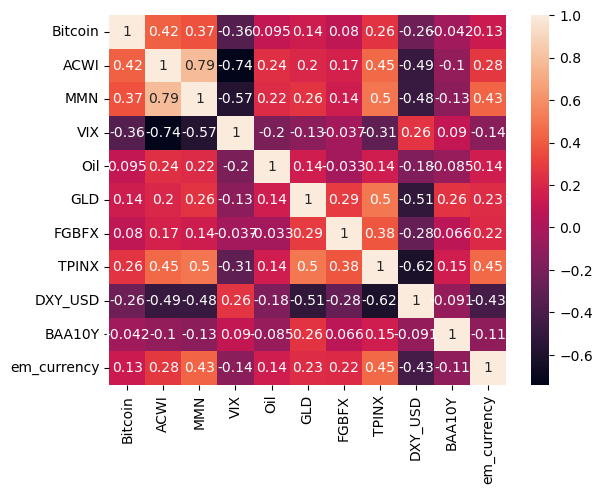

In [4]:
df=lr_data_cleanser(start_date="2020-01-01",end_date=date.today().strftime('%Y-%m-%d'))
sns.heatmap(df.corr(),annot=True);

<div class="alert alert-block alert-info">
<b>BTC Regression Hypothesis 1:</b> BTC and Overall Market (Baseline Regression)
    
</div>


In [5]:
smf.ols('Bitcoin ~ ACWI + MMN + VIX + GLD + Oil +  DXY_USD + FGBFX + TPINX + BAA10Y +em_currency', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Bitcoin   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     16.57
Date:                Wed, 10 May 2023   Prob (F-statistic):           4.58e-27
Time:                        16:08:24   Log-Likelihood:                 1373.1
No. Observations:                 712   AIC:                            -2724.
Df Residuals:                     701   BIC:                            -2674.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0014      0.001      1.044      0.297      -0.001       0.004
ACWI            0.7397      0.249      2.975      0.003       0.252       1.228
MMN             0.2721      0.186      1.461      0.144      -0.094       0.638
VIX            -0.0621      0.026     -2.364      0.018      -0.114      -0.011
GLD             0.0703      0.175      0.401      0.689      -0.274       0.415
Oil            -0.0272      0.054     -0.503      0.615      -0.134       0.079
DXY_USD        -0.4599      0.426     -1.080      0.280      -1.296       0.376
FGBFX          -0.0887      0.437     -0.203      0.839      -0.948       0.770
TPINX           0.5771      0.471      1.225      0.221      -0.348       1.502
BAA10Y         -0.0249      0.043     -0.579      0.563      -0.109       0.060
em_currency    -0.5791      0.641     -0.903      0.367      -1.838       0.680
==============================================================================
Omnibus:                       63.804   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.541
Skew:                           0.324   Prob(JB):                     7.92e-54
Kurtosis:                       5.797   Cond. No.                         500.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b>Function equity_lr_data_cleanser( ) </b>

equity_lr_data_cleanser( ) takes in optional arguements (start_date="yyyy-mm-dd",end_date="yyyy-mm-dd", interval_="1d") where interval is the itnerval of pricing data this should be formatted as a string and can be any of the following:1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo (data type: string)

This function returns a dataframe of the returns for Polygon and the following securities: VTSMX, ACWI, RFG, SLY, IJT, DWM, DEM, IXIC, DJI, GSPC  

In [6]:
#Function for equity markets only import not removed S&P500 due to high multicoliniarity
def equity_lr_data_cleanser(start_date="2020-01-01",end_date=date.today().strftime('%Y-%m-%d'),interval_='1d'):
    equity = ['BTC-USD','VTSMX','ACWI', 'RFG', 'SLY', 'IJT', 'DWM','DEM','^IXIC', '^DJI', '^GSPC' ]
    eq_data = yf.download(equity, start=start_date, end=end_date,interval=interval_,ignore_tz = True)
    eq_df=eq_data['Adj Close'].pct_change()
    cols = eq_df.columns.tolist()
    sorted_eqcols = ['BTC-USD','VTSMX','ACWI', 'RFG', 'SLY', 'IJT', 'DWM','DEM','^IXIC', '^DJI']
    eq_df = eq_df[sorted_eqcols]
    eq_df.rename(columns = {'BTC-USD':'Bitcoin','VTSMX':'Large_Blend','ACWI':'MSCI_ETF','RFG':'MidCap_Growth',
                       'SLY':'Small_Blend','IJT':'Small_Growth','DWM':'Foreign_LargeValue','DEM':'Emerging_Markets',
                       '^IXIC':'Nasdaq','^DJI':'DowJones'}, inplace = True)
    
    return eq_df


[*********************100%***********************]  11 of 11 completed


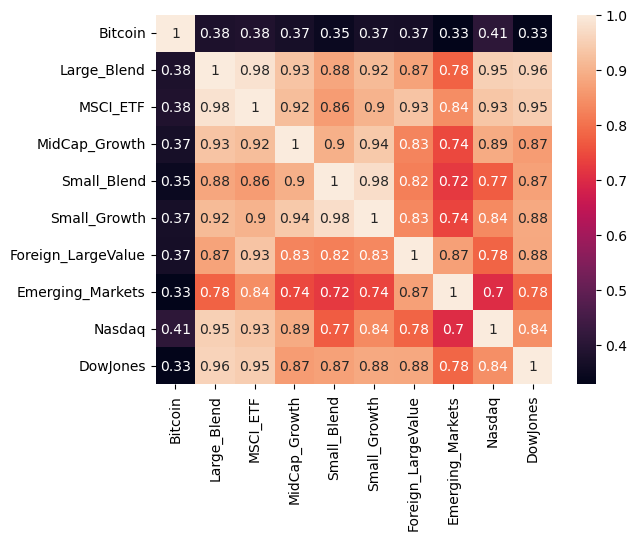

In [7]:
eq_df=equity_lr_data_cleanser(start_date="2020-01-01",end_date=date.today().strftime('%Y-%m-%d'))
sns.heatmap(eq_df.corr(),annot=True);

<div class="alert alert-block alert-info">
<b>BTC Regression Hypothesis 2:</b> Bitcoin and Equities 
    
</div>


In [8]:
smf.ols('Bitcoin ~ Large_Blend + MSCI_ETF + MidCap_Growth + Small_Blend + Small_Growth + Foreign_LargeValue + Emerging_Markets + Nasdaq + DowJones', data=eq_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Bitcoin   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     32.95
Date:                Wed, 10 May 2023   Prob (F-statistic):           4.09e-52
Time:                        16:08:27   Log-Likelihood:                 2432.4
No. Observations:                1223   AIC:                            -4845.
Df Residuals:                    1213   BIC:                            -4794.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0016      0.001      1.648      0.100      -0.000       0.003
Large_Blend           -0.9796      0.980     -0.999      0.318      -2.903       0.944
MSCI_ETF              -1.6004      0.843     -1.899      0.058      -3.254       0.053
MidCap_Growth         -0.2738      0.214     -1.282      0.200      -0.693       0.145
Small_Blend            0.2859      0.321      0.891      0.373      -0.343       0.915
Small_Growth           0.3718      0.378      0.983      0.326      -0.370       1.114
Foreign_LargeValue     1.2569      0.330      3.812      0.000       0.610       1.904
Emerging_Markets       0.2300      0.181      1.269      0.205      -0.126       0.586
Nasdaq                 1.9936      0.367      5.427      0.000       1.273       2.714
DowJones              -0.2131      0.433     -0.492      0.623      -1.062       0.636
==============================================================================
Omnibus:                      130.440   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              981.058
Skew:                          -0.115   Prob(JB):                    9.24e-214
Kurtosis:                       7.382   Cond. No.                     1.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<div class="alert alert-block alert-info">
<b>BTC Regression Hypothesis 3:</b> BTC and Equities during crypto bull markets (2020-2021)

</div>

In [9]:
eq_df_bull=equity_lr_data_cleanser(start_date="2020-01-01",end_date="2021-12-31")
smf.ols('Bitcoin ~ Large_Blend + MSCI_ETF + MidCap_Growth + Small_Blend + Small_Growth + Foreign_LargeValue + Emerging_Markets + Nasdaq + DowJones', data=eq_df_bull).fit().summary()

[*********************100%***********************]  11 of 11 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Bitcoin   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     16.04
Date:                Wed, 10 May 2023   Prob (F-statistic):           4.28e-24
Time:                        16:08:29   Log-Likelihood:                 1377.5
No. Observations:                 728   AIC:                            -2735.
Df Residuals:                     718   BIC:                            -2689.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0029      0.001      2.106      0.036       0.000       0.006
Large_Blend           -0.5522      1.312     -0.421      0.674      -3.128       2.023
MSCI_ETF              -2.0952      1.096     -1.912      0.056      -4.246       0.056
MidCap_Growth         -0.6436      0.299     -2.149      0.032      -1.232      -0.056
Small_Blend            0.2725      0.395      0.690      0.490      -0.502       1.047
Small_Growth           0.6125      0.470      1.304      0.193      -0.310       1.535
Foreign_LargeValue     1.3664      0.443      3.087      0.002       0.497       2.235
Emerging_Markets       0.4477      0.266      1.684      0.093      -0.074       0.970
Nasdaq                 1.9971      0.485      4.120      0.000       1.045       2.949
DowJones              -0.3562      0.616     -0.579      0.563      -1.565       0.852
==============================================================================
Omnibus:                       74.101   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              419.065
Skew:                          -0.220   Prob(JB):                     1.00e-91
Kurtosis:                       6.691   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[*********************100%***********************]  11 of 11 completed


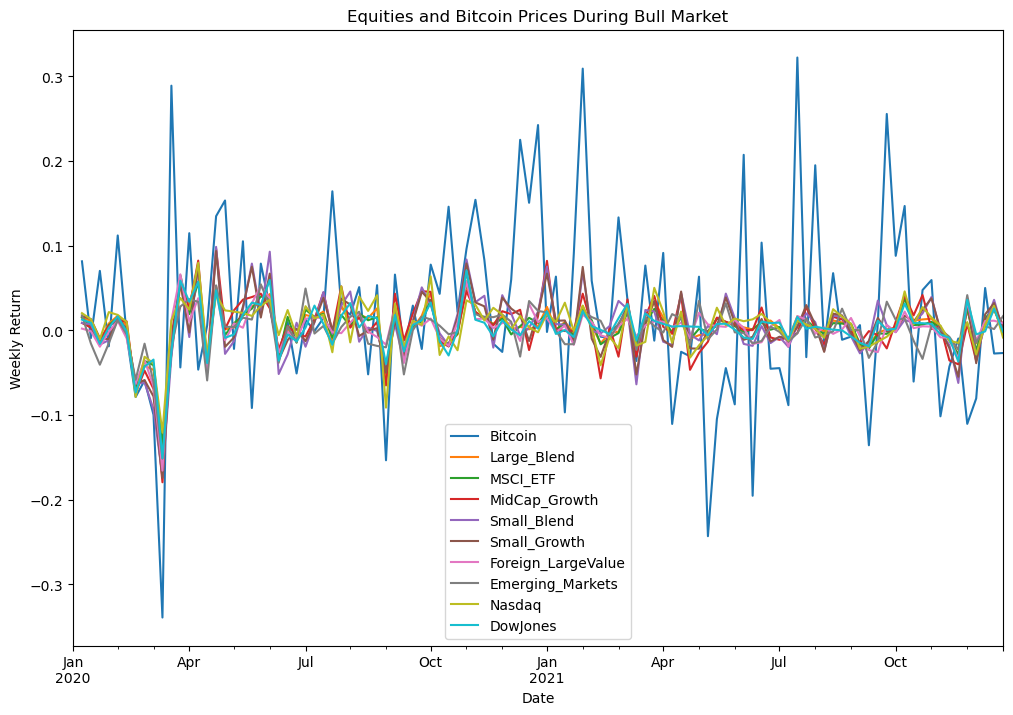

In [10]:
plot_eq_df_bull=equity_lr_data_cleanser(start_date="2020-01-01",end_date="2021-12-31", interval_='1wk')
plot_eq_df_bull.plot(figsize=(12,8))
plt.title('Equities and Bitcoin Prices During Bull Market')
plt.xlabel('Date')
plt.ylabel('Weekly Return')
plt.show()

<div class="alert alert-block alert-info">
<b>BTC Regression Hypothesis 4:</b> BTC and Equities during crypto winter (2022-present)
    
<div>

In [11]:
eq_df_winter=equity_lr_data_cleanser(start_date="2022-01-01",end_date=date.today().strftime('%Y-%m-%d'))
smf.ols('Bitcoin ~ Large_Blend + MSCI_ETF + MidCap_Growth + Small_Blend + Small_Growth + Foreign_LargeValue + Emerging_Markets + Nasdaq + DowJones', data=eq_df_winter).fit().summary()

[*********************100%***********************]  11 of 11 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Bitcoin   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     21.56
Date:                Wed, 10 May 2023   Prob (F-statistic):           1.00e-30
Time:                        16:08:33   Log-Likelihood:                 1078.4
No. Observations:                 491   AIC:                            -2137.
Df Residuals:                     481   BIC:                            -2095.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0002      0.001     -0.186      0.852      -0.003       0.002
Large_Blend           -1.8292      1.500     -1.219      0.223      -4.777       1.119
MSCI_ETF              -1.1745      1.426     -0.824      0.410      -3.976       1.627
MidCap_Growth          0.5832      0.324      1.800      0.072      -0.053       1.220
Small_Blend            0.0727      0.698      0.104      0.917      -1.298       1.444
Small_Growth          -0.3230      0.777     -0.416      0.678      -1.849       1.203
Foreign_LargeValue     1.1287      0.522      2.163      0.031       0.103       2.154
Emerging_Markets       0.0027      0.250      0.011      0.991      -0.488       0.493
Nasdaq                 2.2437      0.597      3.759      0.000       1.071       3.417
DowJones               0.2605      0.641      0.406      0.685      -0.999       1.520
==============================================================================
Omnibus:                       57.438   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.967
Skew:                           0.241   Prob(JB):                     1.01e-76
Kurtosis:                       7.108   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[*********************100%***********************]  11 of 11 completed


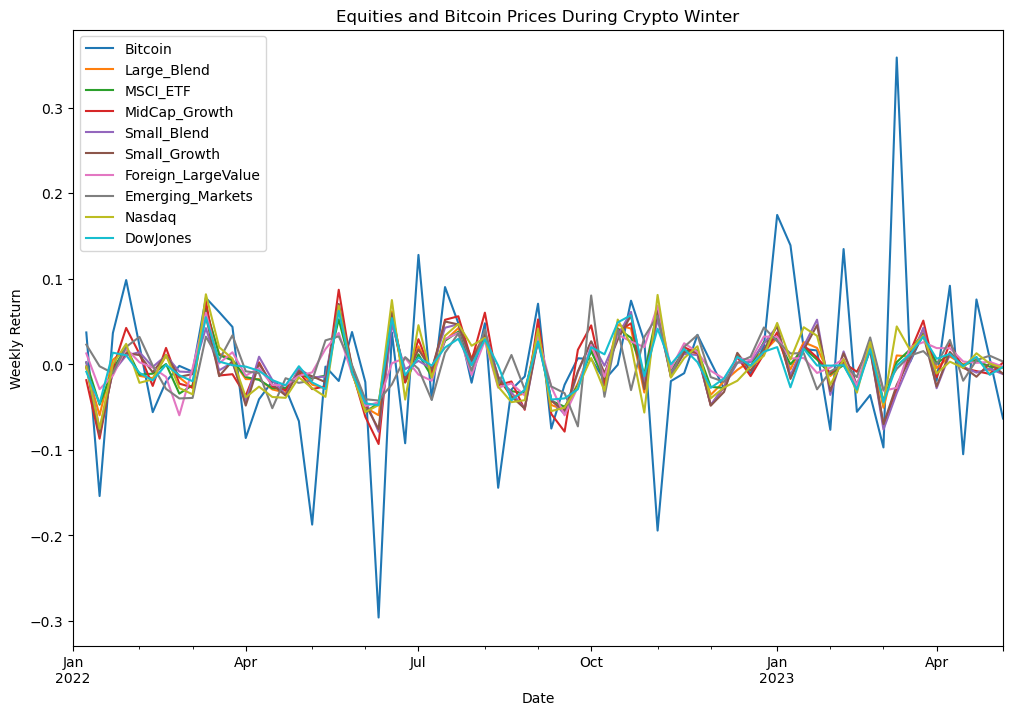

In [12]:
plot_eq_df_winter=equity_lr_data_cleanser(start_date="2022-01-01",end_date=date.today().strftime('%Y-%m-%d'), interval_='1wk')
plot_eq_df_winter.plot(figsize=(12,8))
plt.title('Equities and Bitcoin Prices During Crypto Winter')
plt.xlabel('Date')
plt.ylabel('Weekly Return')
plt.show()

[*********************100%***********************]  11 of 11 completed


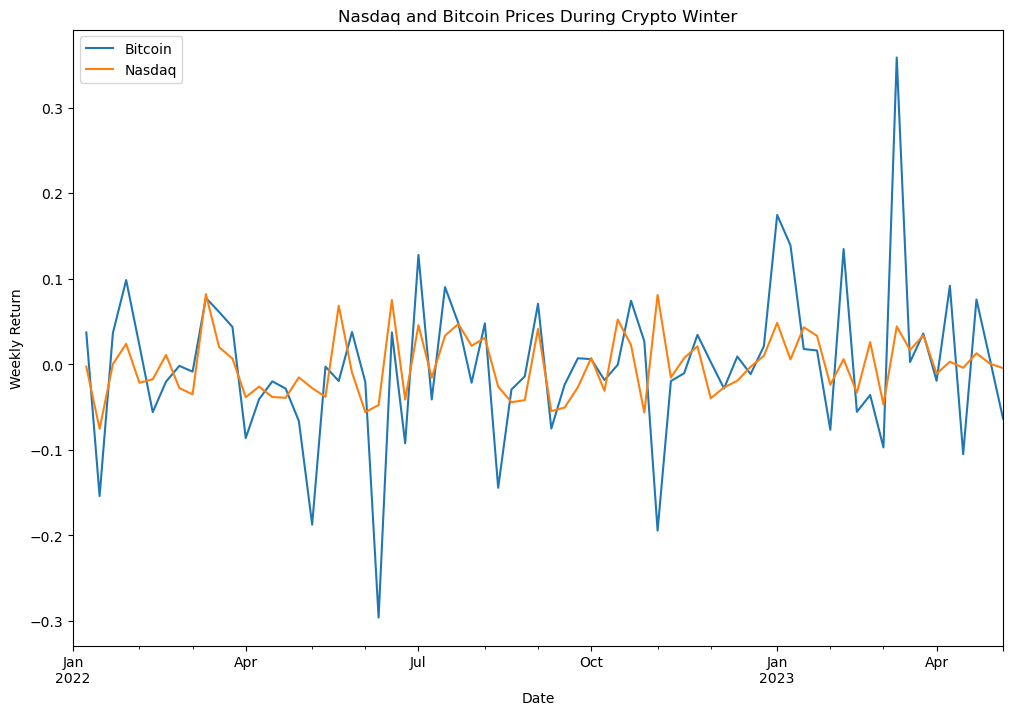

In [13]:
plot_naz_btc_df_winter=equity_lr_data_cleanser(start_date="2022-01-01",end_date=date.today().strftime('%Y-%m-%d'), interval_='1wk')
plot_naz_btc_df_winter=plot_naz_btc_df_winter[['Bitcoin','Nasdaq']]
plot_naz_btc_df_winter.plot(figsize=(12,8))
plt.title('Nasdaq and Bitcoin Prices During Crypto Winter')
plt.xlabel('Date')
plt.ylabel('Weekly Return')
plt.show()

<div class="alert alert-block alert-info">
<b>BTC Regression Hypothesis 5:</b> BTC and Overall Market during crypto bull market (2020-2021)
   
<div>

In [14]:
df_bull=lr_data_cleanser(start_date="2020-01-01",end_date="2021-12-31")

smf.ols('Bitcoin ~ ACWI + MMN + VIX + GLD + Oil +  DXY_USD + FGBFX + TPINX + BAA10Y+em_currency', data=df_bull).fit().summary()

[*********************100%***********************]  9 of 9 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Bitcoin   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     6.056
Date:                Wed, 10 May 2023   Prob (F-statistic):           1.46e-08
Time:                        16:08:38   Log-Likelihood:                 723.46
No. Observations:                 392   AIC:                            -1425.
Df Residuals:                     381   BIC:                            -1381.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0037      0.002      1.828      0.068      -0.000       0.008
ACWI            0.2297      0.478      0.480      0.631      -0.711       1.170
MMN             0.1839      0.295      0.624      0.533      -0.395       0.763
VIX            -0.1067      0.039     -2.703      0.007      -0.184      -0.029
GLD            -0.1250      0.257     -0.486      0.627      -0.631       0.381
Oil            -0.1322      0.096     -1.380      0.168      -0.321       0.056
DXY_USD        -1.5973      0.761     -2.098      0.037      -3.094      -0.100
FGBFX          -0.4852      1.031     -0.471      0.638      -2.512       1.542
TPINX           1.1103      0.949      1.170      0.243      -0.756       2.976
BAA10Y         -0.1620      0.094     -1.717      0.087      -0.348       0.023
em_currency    -0.1104      1.081     -0.102      0.919      -2.236       2.016
==============================================================================
Omnibus:                       23.536   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.541
Skew:                           0.203   Prob(JB):                     1.59e-14
Kurtosis:                       4.930   Cond. No.                         598.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[*********************100%***********************]  9 of 9 completed


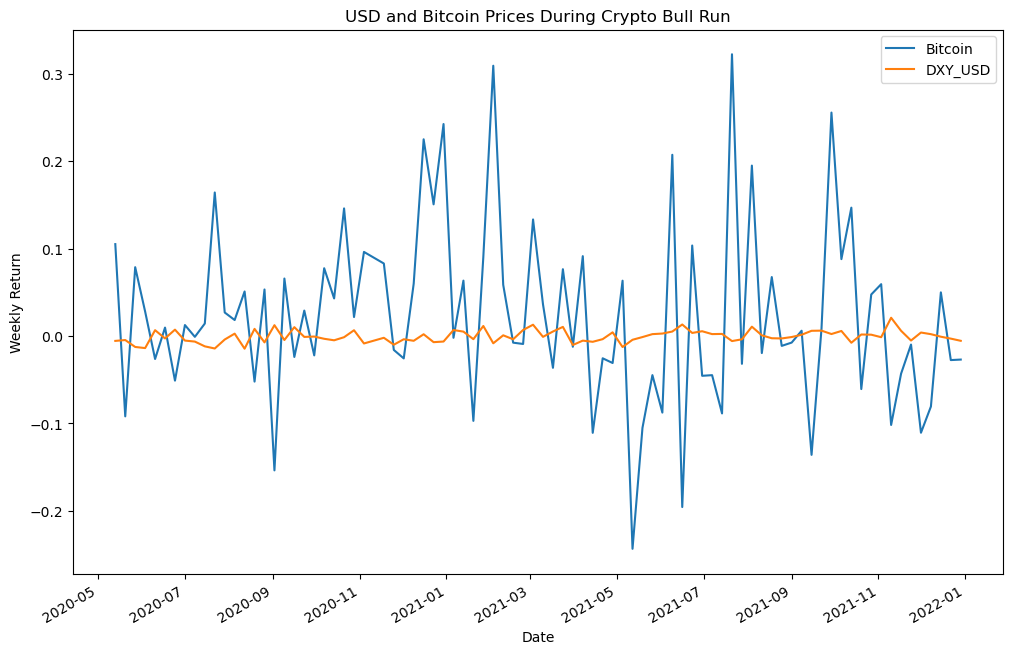

In [29]:
plot_BTC_USD=lr_data_cleanser(start_date="2020-01-01",end_date="2021-12-31",interval_='1wk')
plot_BTC_USD=plot_BTC_USD[['Bitcoin', 'DXY_USD']]
plot_BTC_USD.plot(figsize=(12,8))
plt.title('USD and Bitcoin Prices During Crypto Bull Run')
plt.xlabel('Date')
plt.ylabel('Weekly Return')
plt.show()

<div class="alert alert-block alert-info">
<b>BTC Regression Hypothesis 6:</b> BTC and Overall Market during crypto winter (2022-present)
  
<div>

In [15]:
df_winter=lr_data_cleanser(start_date="2022-01-01",end_date=date.today().strftime('%Y-%m-%d'))

smf.ols('Bitcoin ~ ACWI + MMN + VIX + GLD + Oil +  DXY_USD + FGBFX + TPINX + BAA10Y +em_currency', data=df_winter).fit().summary()

[*********************100%***********************]  9 of 9 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Bitcoin   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     14.30
Date:                Wed, 10 May 2023   Prob (F-statistic):           8.07e-21
Time:                        16:08:39   Log-Likelihood:                 668.23
No. Observations:                 320   AIC:                            -1314.
Df Residuals:                     309   BIC:                            -1273.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0010      0.002     -0.589      0.556      -0.004       0.002
ACWI            1.0052      0.288      3.485      0.001       0.438       1.573
MMN             0.4383      0.232      1.888      0.060      -0.018       0.895
VIX            -0.0310      0.041     -0.755      0.451      -0.112       0.050
GLD             0.1970      0.263      0.748      0.455      -0.321       0.715
Oil             0.0360      0.063      0.567      0.571      -0.089       0.161
DXY_USD         0.1321      0.470      0.281      0.779      -0.792       1.056
FGBFX          -0.0952      0.443     -0.215      0.830      -0.968       0.777
TPINX           0.2151      0.583      0.369      0.712      -0.931       1.361
BAA10Y          0.0274      0.045      0.608      0.544      -0.061       0.116
em_currency    -0.7342      0.754     -0.974      0.331      -2.218       0.750
==============================================================================
Omnibus:                       43.760   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.397
Skew:                           0.391   Prob(JB):                     1.39e-48
Kurtosis:                       6.990   Cond. No.                         471.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[*********************100%***********************]  9 of 9 completed


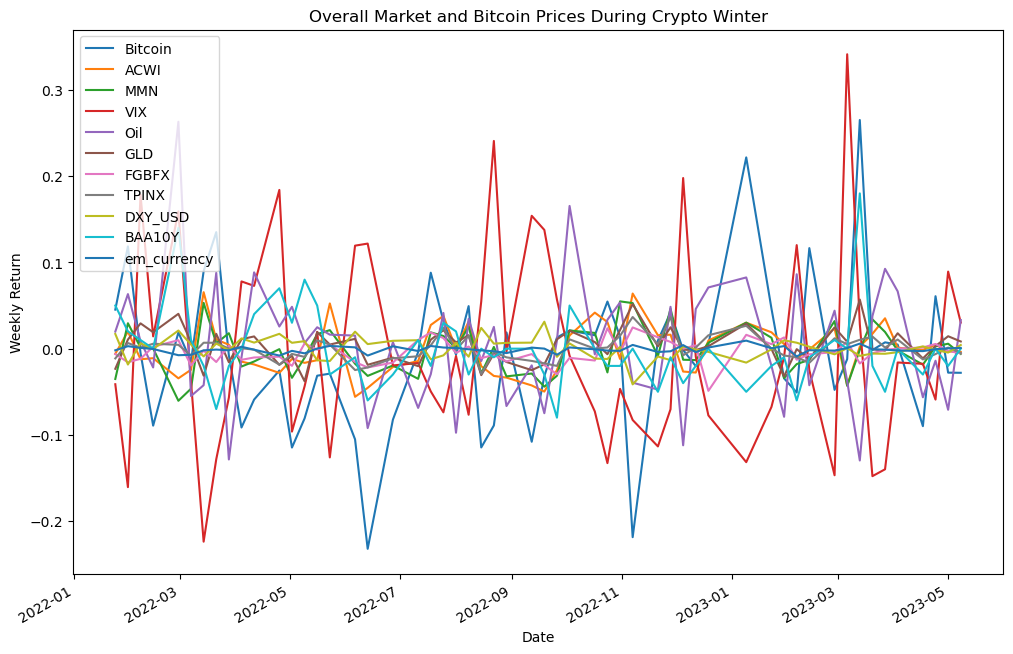

In [16]:
plot_df_winter=lr_data_cleanser(start_date="2022-01-10",end_date=date.today().strftime('%Y-%m-%d'),interval_='1wk')
plot_df_winter.plot(figsize=(12,8))
plt.title('Overall Market and Bitcoin Prices During Crypto Winter')
plt.xlabel('Date')
plt.ylabel('Weekly Return')
plt.legend(loc='upper left')
plt.show()

[*********************100%***********************]  9 of 9 completed


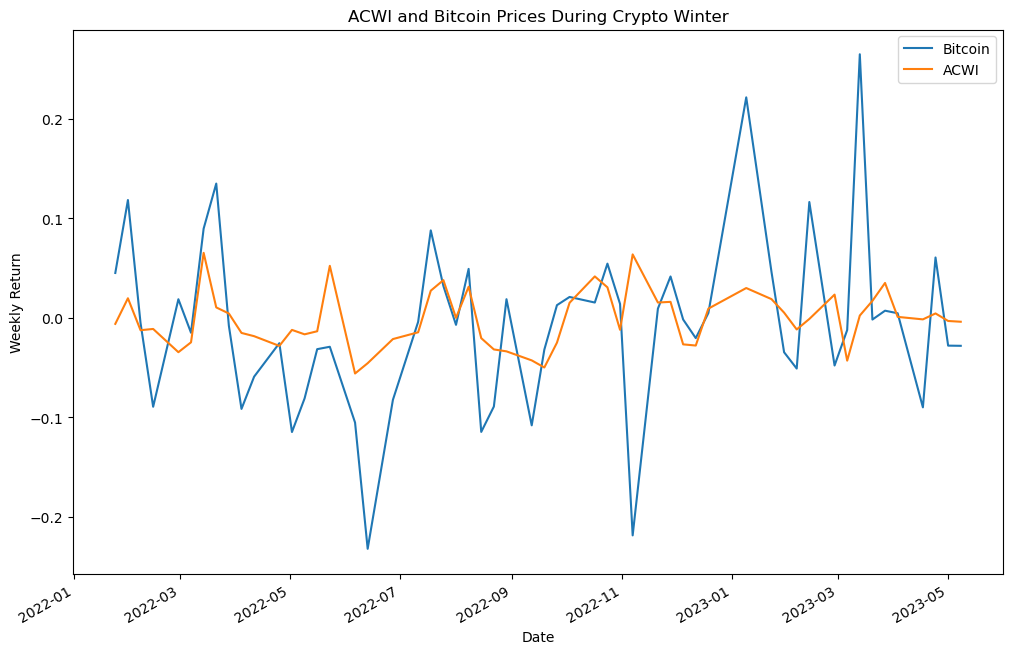

In [18]:
plot_BTC_ACWI=lr_data_cleanser(start_date="2022-01-10",end_date=date.today().strftime('%Y-%m-%d'),interval_='1wk')
plot_BTC_ACWI=plot_BTC_ACWI[['Bitcoin', 'ACWI']]
plot_BTC_ACWI.plot(figsize=(12,8))
plt.title('ACWI and Bitcoin Prices During Crypto Winter')
plt.xlabel('Date')
plt.ylabel('Weekly Return')
plt.show()